# Predicting Google's stock price for Jan 2017 using RNN models

## Part 1: Data Preprocessing

### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

### Importing the training set

In [2]:
data_train = pd.read_csv('C:/Users/Bidee/OneDrive/Desktop/Deep Learning A-Z/Part 3 - Recurrent Neural Networks (RNN)/Google_Stock_Price_Train.csv')
# we only need the opening stock prices so using iloc to slice through the dataset and get the opening values.
# note: Neural Networks only take in arrays and not dataframes. so, reading the dataframe using pandas and after slicing it , this '.values' will convert it to 
# numpy array which is what we need.
train_set = data_train.iloc[:,1:2].values

### Featue scaling

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

train_set_scaled = scaler.fit_transform(train_set)

### Creating a data structure with 60 timesteps and 1 output

In [4]:
x_train = []
y_train = []

for i in range(60, 1258):
    x_train.append(train_set_scaled[i-60:i,0]) #since only 1  column is there so 0
    y_train.append(train_set_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)


# so what the output looks like is a array of 1190, 60 shape. this means that every row now has 60 time steps of data (i.e., spanning across 60 business days)
# starting form column 0 to 59, the next row first value is the 61st day and so on, so every day we look at has past 60 days before it. 

### Reshaping

In [5]:
# we're reshaping it to 3D from 2D because we are adding the corresponting indicator as well. 
# if you have 1 indicator use 1 or other values for multiple indicators.

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Part 2: Building and training the RNN

### Importing keras libraries and packages

In [6]:

from keras.models import Sequential
from keras.layers import LSTM, Dense , Dropout

### Initializing the RNN

In [7]:
regressor = Sequential()

### Adding the first LSTM layer and Dropout regularization

In [8]:
# Here in the input shape, we are adding only 2nd and 3rd dimensions as the first dimension is already taken care of.
# drop out rate of 0.20 meaning 20% of the neurons will be dropped out, so 20% of 50 is 10 , 10 neurons will be dropped out.
regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1), recurrent_dropout = 0.2))
regressor.add(Dropout(0.2))

### Adding the 2nd LSTM layer and Dropout regularization 

In [9]:
regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, recurrent_dropout = 0.2))
regressor.add(Dropout(0.2))

### Adding the 3rd LSTM layer and Drouput regularization

In [10]:
regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, recurrent_dropout = 0.2))
regressor.add(Dropout(0.2))

### Adding the 4th LSTM layer and Drouput regularization 

In [11]:
regressor.add(tf.keras.layers.LSTM(units = 50, recurrent_dropout = 0.2))
regressor.add(Dropout(0.2))

### Adding the output layer

In [12]:
regressor.add(tf.keras.layers.Dense(units = 1)) 

### compiling the RNN

In [13]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error' )

### Fitting the RNN to the training set

In [14]:

with tf.device('/GPU:0'):
    regressor.fit(x = x_train, y= y_train, epochs = 100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 63s 1s/step - loss: 0.0421
Epoch 2/100
38/38 [==============================] - 57s 2s/step - loss: 0.0070
Epoch 3/100
38/38 [==============================] - 58s 2s/step - loss: 0.0063
Epoch 4/100
38/38 [==============================] - 58s 2s/step - loss: 0.0060
Epoch 5/100
38/38 [==============================] - 59s 2s/step - loss: 0.0057
Epoch 6/100
38/38 [==============================] - 59s 2s/step - loss: 0.0061
Epoch 7/100
38/38 [==============================] - 60s 2s/step - loss: 0.0050
Epoch 8/100
38/38 [==============================] - 61s 2s/step - loss: 0.0045
Epoch 9/100
38/38 [==============================] - 62s 2s/step - loss: 0.0047
Epoch 10/100
38/38 [==============================] - 62s 2s/step - loss: 0.0047
Epoch 11/100
38/38 [==============================] - 62s 2s/step - loss: 0.0043
Epoch 12/100
38/38 [==============================] - 62s 2s/step - loss: 0.0043
Epoch 13/100
38/38 [=================

In [15]:
regressor.save('stock_RNN.h5')

## Part 3: Making predictions and visualizing the results

### Getting real stock price of 2017

In [16]:
data_test = pd.read_csv('C:/Users/Bidee/OneDrive/Desktop/Deep Learning A-Z/Part 3 - Recurrent Neural Networks (RNN)/Google_Stock_Price_Test.csv')
real_stock_price = data_test.iloc[:,1:2].values

### Predicting 2017 stock price

In [17]:
dataset_total = pd.concat((data_train['Open'], data_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(data_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test =[]
for i in range(60 ,80):
    x_test.append(inputs[i-60:i , 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# importing the saved model
from keras.models import load_model
rnn = load_model('stock_RNN.h5')
predicted_stock_price = rnn.predict(x_test)
# since the test values are scaled, we would be using inverse transform for actual values. 
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

1/1 [==============================] - 1s 1s/step


### Viz of results

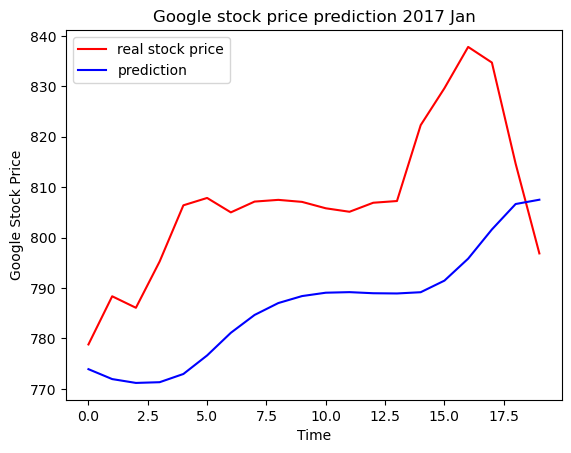

In [18]:
plt.plot(real_stock_price, color = 'red', label = 'real stock price')
plt.plot(predicted_stock_price, color = 'blue', label = 'prediction')
plt.title('Google stock price prediction 2017 Jan')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()